## Graphical Neural Networks: Graph Classification (Part III)

> ### When It Comes to Labeling Not Just Nodes but Whole Graphs
> - Author: Lina Faik
> - Date: August 2022
>
> This notebook is the support that was used to write the article *Graphical Neural Networks: Graph Classification (Part III)* in Medium.
> It contains all the experiments and the results obtained when testing GNN models.
> For more information, you can find the article [here](https://linafaik.medium.com/).

### Table of contents
1. [About the Dataset](#section1)   
 1.1. [Global statistics](#section11)  
 1.2. [Visualization of the molecules](#section12)  
 1.3. [Feature engineering](#section13)  
2. [Graph-Based Modeling](#section2)  
 2.1. [Training a first model](#section21)  
 2.2. [Testing different model hyperparameters for one target](#section22)  
 2.3. [Tuning model hyperparameters for all targets](#section23)  
3. [Explainability](#section3) 

## 1. About the Dataset <a class="anchor" id="section1"></a>
- **Source**: The dataset comes from [MoleculeNet](https://moleculenet.org/datasets-1) (Tox-21) with node and edge enrichment introduced by the [Open Graph Benchmark](https://ogb.stanford.edu/).
- **Description**: The dataset used contains 7 831 molecules. Each molecule is converted into a graph by representing atoms by nodes and replacing the bonds by edges.  These nodes and edges are further enriched with various features to avoid losing valuable information such as the name of the atom or the type of bond. In total, input node features are 9-dimensional and edge features 3-dimensional.
- **Task**: Predict whether a molecule is toxic or not.

### 1.1. Global statistics <a class="anchor" id="section11"></a>

In [144]:
# Import libraries

import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu
from dataiku import insights
from itertools import product
import io, os, json

import time

import py3Dmol
from rdkit import Chem

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.templates.default = "plotly_white"

import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import to_hetero
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, Linear
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn import metrics

%matplotlib inline

In [0]:
# Load dataset

folder = dataiku.Folder("ltkCFtt0")
dataset = MoleculeNet(
    root= os.path.join(folder.get_path(),'molecules_Tox21'), 
    name="Tox21"
)

In [147]:
dataset = dataset.copy()

In [148]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Tox21(7831):
Number of graphs: 7831
Number of features: 9
Number of classes: 12

Data(x=[16, 9], edge_index=[2, 34], edge_attr=[34, 3], y=[1, 12], smiles='CCOc1ccc2nc(S(N)(=O)=O)sc2c1')
Number of nodes: 16
Number of edges: 34
Average node degree: 2.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


### 1.2. Visualization of the molecules <a class="anchor" id="section12"></a>

In [149]:
def draw_molecule(mol):
    
    m = Chem.MolToMolBlock(mol,confId=-1)
    
    p = py3Dmol.view(width=400,height=400)
    p.removeAllModels()
    
    p.addModel(m,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    
    return p.show()

In [150]:
i = 3666 # np.random.randint(len(dataset)) 
m = Chem.MolFromSmiles(dataset[i].smiles)

In [151]:
i

3666

In [152]:
data = dataset[i]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[17, 9], edge_index=[2, 36], edge_attr=[36, 3], y=[1, 12], smiles='Nc1cccc(S(=O)(=O)c2cccc(N)c2)c1')
Number of nodes: 17
Number of edges: 36
Average node degree: 2.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


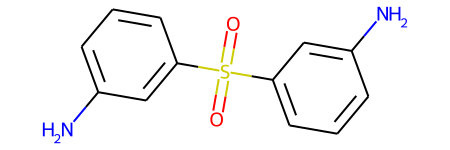

In [153]:
m

In [0]:
draw_molecule(m)

### 1.3. Feature engineering <a class="anchor" id="section13"></a>

In [155]:
for i in range(len(dataset)):
    x_i = dataset[i].x.cpu().detach().numpy()
    x = x_i if i ==0 else np.vstack([x,dataset[i].x.cpu().detach().numpy()])
    
    y_i = dataset[i].y.cpu().detach().numpy()
    y = y_i if i ==0 else np.vstack([y,dataset[i].y.cpu().detach().numpy()])
    
df_x = pd.DataFrame(x)

In [156]:
df_x.columns = [
    'atomic_num', 'chirality', 'degree', 'formal_charge', 
    'numH', 'number_radical_e', 'hybridization', 
    'is_aromatic', 'is_in_ring'
]

In [0]:
for col in df_x:
    px.histogram(
        df_x, col, histnorm='percent',
        height=300, width=500, title='Distribution of '+col).show()

In [158]:
cols_to_normalize = [
    'atomic_num', 'degree', 
    'formal_charge', 
    'numH',  
    'number_radical_e'
]

In [159]:
cols_to_encode = [
    'chirality',
    'hybridization'
]

In [160]:
METHOD = 'min-max'

scalers = {}

for c in cols_to_normalize + cols_to_encode:
    if METHOD == 'normal':
        scalers[c] = {'mean':df_x[c].mean(), 'std':df_x[c].std()}
    if METHOD == 'min-max':
        scalers[c] = {'min': df_x[c].min(), 'max': df_x[c].max()}

In [161]:
scalers['bond_type'] = {'min': 1, 'max': 4}

In [162]:
dataset_new = []

for i in range(len(dataset)):
    data = dataset[i]
    x_norm = data.x.detach().cpu().numpy().astype(float)
    edge_w_norm = data.edge_attr[:,0].detach().cpu().numpy().astype(float)
    edge_a_norm = data.edge_attr[:,0].detach().cpu().numpy().astype(int)
    
    # normalize columns
    for c in cols_to_normalize:
        col_i = list(df_x.columns).index(c)
        
        if METHOD == 'normal':
            x_norm[:, col_i] = (x_norm[:, col_i] - scalers[c]['mean'])/scalers[c]['std']
        if METHOD == 'min-max':
            x_norm[:, col_i] = (x_norm[:, col_i] - scalers[c]['min'])/(scalers[c]['max'] - scalers[c]['min'])
    
    # one-hot encoding of categorical columns
    for i,c in enumerate(cols_to_encode):
    
        col = x_norm[:,list(df_x.columns).index(c)].astype(int)
        col_enc = np.zeros((col.size, scalers[c]['max']+1))
        col_enc[np.arange(col.size),col] = 1

        cols_encoded = col_enc if i == 0 else np.hstack([cols_encoded, col_enc])

    cols_i_to_encode = [list(df_x.columns).index(c) for c in cols_to_encode] 
    x_norm = x_norm[:,[i for i in range(x_norm.shape[1]) if i not in cols_i_to_encode]]
    x_norm = np.hstack([x_norm, cols_encoded])
    
    # normalize type of bonds
    edge_w_norm = (edge_w_norm - scalers['bond_type']['min'])/(scalers['bond_type']['max'] - scalers['bond_type']['min'])
    
    # one-hot encoding of type of bonds
    edge_a_norm = data.edge_attr[:,0].detach().cpu().numpy().astype(int)
    col_enc = np.zeros((edge_a_norm.size, scalers['bond_type']['max']+1))
    col_enc[np.arange(edge_a_norm.size),edge_a_norm] = 1
    
    # saving results
    data.x_norm = torch.tensor(x_norm, dtype=torch.float)
    data.edge_w_norm = torch.tensor(edge_w_norm, dtype=torch.float)
    data.edge_a_norm = torch.tensor(col_enc, dtype=torch.float)
    
    dataset_new.append(data)

In [163]:
df_y = pd.DataFrame(y).melt()

In [164]:
df_y1 = df_y.groupby(['variable'],as_index=False).agg({'value':['sum', 'count']})
df_y1.columns = ['variable','sum', 'count']
df_y1['mean'] = df_y1['sum']/df_y1['count']
df_y1['missing_values'] = (1 - df_y1['count'] / len(dataset))

In [165]:
for c in ['mean', 'missing_values']:
    df_y1[c] = df_y1[c].apply(lambda x:round(x*100,2))

## 2. Graph-Based Modeling  <a class="anchor" id="section2"></a>

The objective of this section is to train graph-based models to predict whether a molecule is toxic or not.  For each model, it tests and evaluates different hyperparameters.

### 2.1. Training a first model <a class="anchor" id="section21"></a>

In [168]:
TARGET = 2

In [169]:
dataset_target, Y = [], []

for i in range(len(dataset_new)):
    if not(dataset_new[i]['y'][0,TARGET].isnan()):
        Y.append(dataset_new[i]['y'][0,TARGET])
        dataset_target.append(dataset_new[i])
        
Y = pd.DataFrame([y.numpy() for y in Y]).reset_index().rename(columns={0:'target'})

In [170]:
Y.target.mean()*100

11.726981401443481

In [171]:
class_weights = torch.tensor([Y.target.mean(), 1-Y.target.mean()])

In [172]:
def split_dataset(dataset_target, Y, test_size=0.25, random_state=None):
    random_state = np.random.randint(10**3) if random_state is None else random_state
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state = random_state)

    train_dataset, test_dataset = [], []
    for train_index, test_index in sss.split(Y['index'], Y['target']):
        train_dataset += [dataset_target[i] for i in list(train_index)]
        test_dataset += [dataset_target[i] for i in list(test_index)]

    print(f'Number of training graphs: {len(train_dataset)} -> {round(len(train_dataset)/len(dataset_target)*100)}%')
    print(f'Number of test graphs: {len(test_dataset)} -> {round(len(test_dataset)/len(dataset_target)*100)}%')
    
    return train_dataset, test_dataset 

In [173]:
train_dataset, test_dataset = split_dataset(dataset_target, Y)

Number of training graphs: 4911 -> 75%
Number of test graphs: 1638 -> 25%


In [174]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=120)
test_loader = DataLoader(test_dataset, batch_size=120)

In [175]:
train_dataset[0]

Data(x=[15, 9], edge_index=[2, 34], edge_attr=[34, 3], y=[1, 12], smiles='O=C1O[Pt]2(N[C@@H]3CCCC[C@H]3N2)OC1=O', x_norm=[15, 17], edge_w_norm=[34], edge_a_norm=[34, 5])

In [176]:
from torch.nn import Linear, Softmax
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, TransformerConv
from torch_geometric.nn import global_mean_pool


class GNN(torch.nn.Module):
    def __init__(self, input_size, hidden_channels, conv, conv_params={}):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = conv(
            input_size, hidden_channels, **conv_params)
        self.conv2 = conv(
            hidden_channels, hidden_channels, **conv_params)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch,  edge_col = None):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_col)

        # 2. Readout layer
        batch = torch.zeros(data.x.shape[0],dtype=int) if batch is None else batch
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
    
        return x

model = GNN(input_size = 17, hidden_channels=64, conv = GCNConv)
print(model)

GNN(
  (conv1): GCNConv(17, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [177]:
def train(train_loader, model, target, optimizer, criterion, edge_col_name):
    model.train()
    
    losses = []

    for data in train_loader:  # Iterate in batches over the training dataset.
        if edge_col_name==None:
            out = model(data.x_norm, data.edge_index, data.batch) 
        else:
            out = model(data.x_norm, data.edge_index, data.batch, data[edge_col_name]) 
        
        loss = criterion(out, data.y[:,target].long())  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        losses.append(loss.cpu().detach().numpy())
        
    return np.mean(losses)

def test(loader, model, target, edge_col_name, metric = metrics.accuracy_score):
    
    model.eval()
    
    score = 0
    for data in loader:
        if edge_col_name==None:
            out = model(data.x_norm, data.edge_index, data.batch) 
        else:
            out = model(data.x_norm, data.edge_index, data.batch, data[edge_col_name]) 
            
        y_pred = out.argmax(dim=1).detach().numpy()
        y_true = data.y[:,target].long().cpu().detach().numpy()
        
        score += metric(y_true, y_pred)
    
    return score/len(loader)

def train_test(
    train_loader, test_loader, model, model_params, target, class_weights, edge_col_name=None, 
    learning_rate=0.01, e_patience = 10, min_acc= 0.005, n_epochs=500):
    t0 = time.time()

    model = model(**model_params)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss(weight = class_weights)

    k=0
    
    loss, train_score, test_score = [], [], []
    
    for epoch in range(n_epochs):
        loss += [train(train_loader, model, target, optimizer, criterion, edge_col_name)]
        train_score += [test(train_loader, model, target, edge_col_name)]
        test_score += [test(test_loader, model, target, edge_col_name)]
        
        if (epoch+1)%10==0:
            print(f'Epoch: {epoch+1:03d}, Loss: {loss[-1]:.4f}, Train: {train_score[-1]:.4f}, Test: {test_score[-1]:.4f}')

        results = pd.DataFrame({
            'loss': loss,
            'train_score': train_score, 'test_score': test_score,
            'time':(time.time()-t0)/60
        })

        # enable early stopping
        if (epoch > 1) and abs(loss[-1]/loss[-2]-1) < min_acc :
            k += 1
        if k> e_patience:
            print('Early stopping, epoch', epoch)
            break

    return model, results

def visualize_loss(results):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=results.index, y=results['train_score'], name = 'train_score'))
    fig.add_trace(go.Scatter(x=results.index, y=results['test_score'], name = 'test_score'))
    fig.add_trace(go.Scatter(x=results.index, y=results['loss'], name = 'loss'))

    fig.update_yaxes(title_text='Score')
    fig.update_xaxes(title_text="Epoch")
    
    fig.update_yaxes(range=[0,1.3*max([max(results[c]) for c in ['loss', 'train_score', 'test_score']])])
    

    return fig

In [178]:
N_EPOCHS = 500
E_PATIENCE = 50
LEARNING_RATE = 0.01

In [182]:
model_params = {"input_size":17, "hidden_channels":32, 'conv':GCNConv}

model, results = train_test(
    train_loader, test_loader, GNN, model_params, target = TARGET, class_weights = class_weights, 
    learning_rate=LEARNING_RATE, e_patience = E_PATIENCE, n_epochs=N_EPOCHS)

Epoch: 010, Loss: 0.5266, Train: 0.6903, Test: 0.6768
Epoch: 020, Loss: 0.5218, Train: 0.7162, Test: 0.7108
Epoch: 030, Loss: 0.5112, Train: 0.7420, Test: 0.7412
Epoch: 040, Loss: 0.4992, Train: 0.7241, Test: 0.7224
Epoch: 050, Loss: 0.4938, Train: 0.7406, Test: 0.7340
Epoch: 060, Loss: 0.4849, Train: 0.7425, Test: 0.7361
Epoch: 070, Loss: 0.4847, Train: 0.7214, Test: 0.7165
Epoch: 080, Loss: 0.4835, Train: 0.7297, Test: 0.7261
Epoch: 090, Loss: 0.4796, Train: 0.7211, Test: 0.7171
Epoch: 100, Loss: 0.4761, Train: 0.7394, Test: 0.7302
Early stopping, epoch 108


### 2.2. Testing different model hyperparameters for one target <a class="anchor" id="section22"></a>

#### ... GCN vs. GAT layers

In [183]:
N = 3

In [184]:
def train_test_CV(dataset_target, Y, GNN, model_params, target, 
                  class_weights,edge_col_name = None, 
                  learning_rate=0.01, e_patience = 10, min_acc= 0.005, n_epochs=500, N=3):

    for i in range(N):
        
        train_dataset, test_dataset = split_dataset(dataset_target, Y)

        train_loader = DataLoader(train_dataset, batch_size=120)
        test_loader = DataLoader(test_dataset, batch_size=120)
        
        model, results = train_test(
            train_loader, test_loader,
            GNN, model_params, target, class_weights, edge_col_name,
            learning_rate, e_patience, n_epochs = n_epochs)
        
        results_df = results.iloc[-1:] if i == 0 else pd.concat([results_df, results.iloc[-1:]])
        
        print(results_df)
        
    means = pd.DataFrame(results_df.mean()).T.rename(columns={c:c+'_mean' for c in results_df.columns})
    stds = pd.DataFrame(results_df.std()).T.rename(columns={c:c+'_std' for c in results_df.columns})
    results_df = pd.concat([means, stds], axis=1).reset_index(drop=True)
      
    return model, results_df

In [0]:
model, results =  train_test_CV(
    dataset_target, Y, GNN, model_params, target = TARGET,
    class_weights = class_weights,edge_col_name=None,
    learning_rate=LEARNING_RATE, e_patience = E_PATIENCE, n_epochs=N_EPOCHS, N=3)

In [186]:
results['model'] = 'GCNConv'
results_df = results
results_df

,loss_mean,train_score_mean,test_score_mean,time_mean,loss_std,train_score_std,test_score_std,time_std,model
0,0.489916,0.749086,0.741056,2.206384,0.007948,0.041765,0.058838,0.1819,GCNConv


In [187]:
y_pred, y_true = [], []

model.eval()
for data in test_dataset:
    out =  model(data.x_norm, data.edge_index, batch=None) 
    y_pred += [out.argmax(dim=1).detach().numpy()]
    y_true += [data.y[:,TARGET].long().cpu().detach().numpy()]

print(metrics.classification_report(y_true, y_pred))

model_metrics = {
    'accuracy': metrics.accuracy_score(y_true, y_pred),
    'precision':  metrics.precision_score(y_true, y_pred),
    'recall':  metrics.recall_score(y_true, y_pred),
    'f1-recall':  metrics.recall_score(y_true, y_pred),
}

model_metrics

              precision    recall  f1-score   support

           0       0.96      0.79      0.87      1446
           1       0.33      0.76      0.46       192

    accuracy                           0.79      1638
   macro avg       0.65      0.78      0.66      1638
weighted avg       0.89      0.79      0.82      1638



{'accuracy': 0.7905982905982906,
 'precision': 0.3295711060948081,
 'recall': 0.7604166666666666,
 'f1-recall': 0.7604166666666666}

In [0]:
model_params = {"input_size":17, "hidden_channels":32, 'conv':GATConv}

model, results = train_test_CV(
    dataset_target, Y, GNN, model_params, target = TARGET, class_weights = class_weights, 
    learning_rate=LEARNING_RATE, e_patience = E_PATIENCE, n_epochs=N_EPOCHS)

results['model'] = 'GATConv'
results_df = pd.concat([results_df, results], axis=0)

In [189]:
results_df

,loss_mean,train_score_mean,test_score_mean,time_mean,loss_std,train_score_std,test_score_std,time_std,model
0,0.489916,0.749086,0.741056,2.206384,0.007948,0.041765,0.058838,0.18190,GCNConv
0,0.506232,0.714801,0.709096,2.486684,0.011140,0.069543,0.056365,0.34252,GATConv


In [190]:
y_pred, y_true = [], []

model.eval()
for data in test_dataset:
    out =  model(data.x_norm, data.edge_index, batch=None) 
    y_pred += [out.argmax(dim=1).detach().numpy()]
    y_true += [data.y[:,TARGET].long().cpu().detach().numpy()]

print(metrics.classification_report(y_true, y_pred))

model_metrics = {
    'accuracy': metrics.accuracy_score(y_true, y_pred),
    'precision':  metrics.precision_score(y_true, y_pred),
    'recall':  metrics.recall_score(y_true, y_pred),
    'f1-recall':  metrics.recall_score(y_true, y_pred),
}

model_metrics

              precision    recall  f1-score   support

           0       0.97      0.69      0.80      1446
           1       0.26      0.83      0.39       192

    accuracy                           0.70      1638
   macro avg       0.61      0.76      0.60      1638
weighted avg       0.88      0.70      0.75      1638



{'accuracy': 0.702075702075702,
 'precision': 0.25895765472312704,
 'recall': 0.828125,
 'f1-recall': 0.828125}

#### ... 2 vs. 3 layers

In [191]:
class GNN_3l(torch.nn.Module):
    def __init__(self, input_size, hidden_channels, conv, conv_params={}):
        super(GNN_3l, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = conv(
            input_size, hidden_channels, **conv_params)
        self.conv2 = conv(
            hidden_channels, hidden_channels, **conv_params)
        self.conv3 = conv(
            hidden_channels, hidden_channels, **conv_params)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch,  edge_col=None):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        batch = torch.zeros(data.x.shape[0],dtype=int) if batch is None else batch
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
    
        return x

In [0]:
model_params = {"input_size":17, "hidden_channels":32, 'conv':GCNConv}

model, results = train_test_CV(
    dataset_target, Y, GNN_3l, model_params, target = TARGET, class_weights = class_weights, 
    learning_rate=LEARNING_RATE, e_patience = E_PATIENCE, n_epochs=N_EPOCHS)

results['model'] = 'GCNConv'
results_df['nb_layers'] = 2
results['nb_layers'] = 3
results_df = pd.concat([results_df, results], axis=0)

In [193]:
results_df

,loss_mean,train_score_mean,test_score_mean,time_mean,loss_std,train_score_std,test_score_std,time_std,model,nb_layers
0,0.489916,0.749086,0.741056,2.206384,0.007948,0.041765,0.058838,0.181900,GCNConv,2
0,0.506232,0.714801,0.709096,2.486684,0.011140,0.069543,0.056365,0.342520,GATConv,2
0,0.462576,0.778957,0.776862,3.468169,0.032716,0.042906,0.037108,0.908766,GCNConv,3


In [194]:
y_pred, y_true = [], []

model.eval()
for data in test_dataset:
    out =  model(data.x_norm, data.edge_index, batch=None) 
    y_pred += [out.argmax(dim=1).detach().numpy()]
    y_true += [data.y[:,TARGET].long().cpu().detach().numpy()]

print(metrics.classification_report(y_true, y_pred))

model_metrics = {
    'accuracy': metrics.accuracy_score(y_true, y_pred),
    'precision':  metrics.precision_score(y_true, y_pred),
    'recall':  metrics.recall_score(y_true, y_pred),
    'f1-recall':  metrics.recall_score(y_true, y_pred),
}
model_metrics

              precision    recall  f1-score   support

           0       0.98      0.74      0.85      1446
           1       0.31      0.89      0.46       192

    accuracy                           0.76      1638
   macro avg       0.65      0.81      0.66      1638
weighted avg       0.90      0.76      0.80      1638



{'accuracy': 0.7606837606837606,
 'precision': 0.3148148148148148,
 'recall': 0.8854166666666666,
 'f1-recall': 0.8854166666666666}

#### ... using edge data

In [0]:
# using edge_weight for GCN

model_params = {"input_size":17, "hidden_channels":32, 'conv':GCNConv}

model, results = train_test_CV(
    dataset_target, Y, GNN_3l, model_params, target = TARGET, 
    class_weights = class_weights,  edge_col_name='edge_w_norm', 
    learning_rate=LEARNING_RATE, e_patience = E_PATIENCE, n_epochs=N_EPOCHS)

results['model'] = 'GCNConv'
results['nb_layers'] = 3
results['edge_weight'] = True
results_df['edge_weight'] = False

results_df = pd.concat([results_df, results], axis=0)

In [196]:
results_df

,loss_mean,train_score_mean,test_score_mean,time_mean,loss_std,train_score_std,test_score_std,time_std,model,nb_layers,edge_weight
0,0.489916,0.749086,0.741056,2.206384,0.007948,0.041765,0.058838,0.181900,GCNConv,2,False
0,0.506232,0.714801,0.709096,2.486684,0.011140,0.069543,0.056365,0.342520,GATConv,2,False
0,0.462576,0.778957,0.776862,3.468169,0.032716,0.042906,0.037108,0.908766,GCNConv,3,False
0,0.490190,0.704971,0.687195,3.104505,0.017238,0.023007,0.022712,0.209168,GCNConv,3,True


In [197]:
y_pred, y_true = [], []

model.eval()
for data in test_dataset:
    out =  model(data.x_norm, data.edge_index, batch=None) 
    y_pred += [out.argmax(dim=1).detach().numpy()]
    y_true += [data.y[:,TARGET].long().cpu().detach().numpy()]

print(metrics.classification_report(y_true, y_pred))

model_metrics = {
    'accuracy': metrics.accuracy_score(y_true, y_pred),
    'precision':  metrics.precision_score(y_true, y_pred),
    'recall':  metrics.recall_score(y_true, y_pred),
    'f1-recall':  metrics.recall_score(y_true, y_pred),
}

model_metrics

              precision    recall  f1-score   support

           0       0.96      0.71      0.82      1446
           1       0.26      0.78      0.39       192

    accuracy                           0.72      1638
   macro avg       0.61      0.74      0.61      1638
weighted avg       0.88      0.72      0.77      1638



{'accuracy': 0.721001221001221,
 'precision': 0.26465364120781526,
 'recall': 0.7760416666666666,
 'f1-recall': 0.7760416666666666}

In [0]:
# using edge_attr for GAT

model_params = {"input_size":17, "hidden_channels":32, 'conv':GATConv, 'conv_params' : {'edge_dim':5}}

model, results = train_test_CV(
    dataset_target, Y, GNN_3l, model_params, target = TARGET, 
    class_weights = class_weights,  edge_col_name='edge_a_norm', 
    learning_rate=LEARNING_RATE, e_patience = E_PATIENCE, n_epochs=N_EPOCHS)

results['model'] = 'GATConv'
results['nb_layers'] = 3
results['edge_weight'] = False
results['edge_attr'] = True
results_df['edge_attr'] = False

results_df = pd.concat([results_df, results], axis=0)

In [199]:
results_df

,loss_mean,train_score_mean,test_score_mean,time_mean,loss_std,train_score_std,test_score_std,time_std,model,nb_layers,edge_weight,edge_attr
0,0.489916,0.749086,0.741056,2.206384,0.007948,0.041765,0.058838,0.181900,GCNConv,2,False,False
0,0.506232,0.714801,0.709096,2.486684,0.011140,0.069543,0.056365,0.342520,GATConv,2,False,False
0,0.462576,0.778957,0.776862,3.468169,0.032716,0.042906,0.037108,0.908766,GCNConv,3,False,False
0,0.490190,0.704971,0.687195,3.104505,0.017238,0.023007,0.022712,0.209168,GCNConv,3,True,False
0,0.435221,0.802822,0.797527,7.912181,0.014868,0.019057,0.003241,1.658081,GATConv,3,False,True


In [200]:
y_pred, y_true = [], []

model.eval()
for data in test_dataset:
    out =  model(data.x_norm, data.edge_index, batch=None) 
    y_pred += [out.argmax(dim=1).detach().numpy()]
    y_true += [data.y[:,TARGET].long().cpu().detach().numpy()]

print(metrics.classification_report(y_true, y_pred))

model_metrics = {
    'accuracy': metrics.accuracy_score(y_true, y_pred),
    'precision':  metrics.precision_score(y_true, y_pred),
    'recall':  metrics.recall_score(y_true, y_pred),
    'f1-recall':  metrics.recall_score(y_true, y_pred),
}

model_metrics

              precision    recall  f1-score   support

           0       0.92      0.87      0.90      1446
           1       0.32      0.44      0.37       192

    accuracy                           0.82      1638
   macro avg       0.62      0.66      0.63      1638
weighted avg       0.85      0.82      0.84      1638



{'accuracy': 0.8229548229548229,
 'precision': 0.31716417910447764,
 'recall': 0.4427083333333333,
 'f1-recall': 0.4427083333333333}

In [201]:
results_df = results_df.sort_values(by='test_score_mean',ascending=False).reset_index(drop=True)
results_df

,loss_mean,train_score_mean,test_score_mean,time_mean,loss_std,train_score_std,test_score_std,time_std,model,nb_layers,edge_weight,edge_attr
0,0.435221,0.802822,0.797527,7.912181,0.014868,0.019057,0.003241,1.658081,GATConv,3,False,True
1,0.462576,0.778957,0.776862,3.468169,0.032716,0.042906,0.037108,0.908766,GCNConv,3,False,False
2,0.489916,0.749086,0.741056,2.206384,0.007948,0.041765,0.058838,0.181900,GCNConv,2,False,False
3,0.506232,0.714801,0.709096,2.486684,0.011140,0.069543,0.056365,0.342520,GATConv,2,False,False
4,0.490190,0.704971,0.687195,3.104505,0.017238,0.023007,0.022712,0.209168,GCNConv,3,True,False


### 2.3. Tuning model hyperparameters for all targets <a class="anchor" id="section23"></a>

In [181]:
hidden_channels = [32, 64]#, 16]
convs = [GATConv, GCNConv]#, SAGEConv]
learning_rates = [0.01]#, 0.05]
n_layers = [2]#,3]
with_edge_data = [True, False]

In [180]:
def run_grid_search_target(target, hidden_channels, convs, 
                           learning_rates, n_layers, with_edge_data,
                           random_state=0
                          ):
    dataset_target, Y = [], []

    for i in range(len(dataset_new)):
        if not(dataset_new[i]['y'][0,target].isnan()):
            Y.append(dataset_new[i]['y'][0,target])
            dataset_target.append(dataset_new[i])

    Y = pd.DataFrame([y.numpy() for y in Y]).reset_index().rename(columns={0:'target'})
    class_weights = torch.tensor([Y.target.mean(), 1-Y.target.mean()])
    train_dataset, test_dataset = split_dataset(dataset_target, Y)
    
    n_sc = len(hidden_channels)*len(learning_rates)*len(convs)*len(n_layers)*len(with_edge_data)

    i=0

    for hc, lr, c, n, ed in product(hidden_channels, learning_rates, convs, n_layers, with_edge_data):
        print()
        print('Sc: {}/{}'.format(i+1, n_sc))
        name_conv = str(c).split('.')[-1].replace('\'>', "")
        print({'hidden_channels':hc, 'learning_rate': lr, 
               'conv':name_conv, 'n_layers':n, 'with_edge_data': True})

        model_params = {"input_size":17, 'hidden_channels':hc, 'conv':c}
        
        algo = GNN if n == 2 else GNN_3l
        
        if not(ed):
            edge_col_name = None
            run_flag = True
        else:
            if name_conv == "GCNConv":
                edge_col_name = "edge_w_norm"
                run_flag = True
            elif name_conv == "GATConv":
                edge_col_name = "edge_a_norm"
                model_params['conv_params'] = {'edge_dim':5}
                run_flag = True
            else:
                run_flag = False
        
        if run_flag:
            
            model, results = train_test_CV(
                dataset_target, Y, algo, model_params, target = target, 
                class_weights = class_weights, edge_col_name = edge_col_name,
                learning_rate=lr, e_patience = E_PATIENCE, n_epochs=N_EPOCHS)

            results['model'] = name_conv
            results['hc'] = hc
            results['lr'] = lr
            results['n_layers'] = n
            results['with_edge_data'] = ed

            results_df = results if i==0 else pd.concat([results_df, results], axis=0)
            results_df.reset_index(drop=True, inplace=True)
            

            display(results_df)

            i+=1

    if i>0:
        results_df['target'] = target
        results_df['perc_class'] = Y.target.mean()
        cols = ['target', 'model', 'hc', 'lr']
        results_df = results_df[
            cols+[c for c in results_df.columns if c not in cols]
        ].sort_values(by='test_score_mean').reset_index(drop=True)

        return results_df

In [0]:
results_target = run_grid_search_target(
    TARGET, hidden_channels, convs, learning_rates, n_layers, with_edge_data)

In [0]:
for target in range(0,12):
    print('Target {}/{}'.format(target+1, 12))
    results_target = run_grid_search_target(
        target, hidden_channels, convs, learning_rates, n_layers, with_edge_data)
    results_all_targets = results_target if target == 0 else pd.concat([results_target, results_all_targets], axis=0)
    
    results_all_targets.reset_index(drop=True, inplace=True)
    
    display(results_all_targets)
    print('---'*10)

In [85]:
tmp = results_all_targets.groupby(['target'],as_index=False).agg({
    'test_score_mean': max
})

In [130]:
tmp2 = tmp.merge(results_all_targets,how='left', on = ['target', 'test_score_mean'])
tmp2 = tmp2.merge(df_y1[['variable', 'count', 'missing_values']].rename(columns = {'variable' : 'target'}), 
           on='target',how='left')
tmp2

,target,test_score_mean,model,hc,lr,loss_mean,train_score_mean,time_mean,loss_std,train_score_std,test_score_std,time_std,n_layers,with_edge_data,perc_class,count,missing_values
0,0,0.939532,GATConv,64,0.01,0.472631,0.948128,5.262704,0.012797,0.007279,0.005155,0.833050,2,False,0.042533,7265,7.23
1,1,0.945556,GATConv,64,0.01,0.416286,0.954254,10.240985,0.012099,0.005343,0.012184,1.507740,2,True,0.035070,6758,13.70
2,2,0.781090,GATConv,64,0.01,0.472442,0.788200,6.943089,0.020268,0.032355,0.029499,2.163584,2,True,0.117270,6549,16.37
3,3,0.715171,GATConv,64,0.01,0.588105,0.709484,4.563357,0.027484,0.069081,0.080620,0.060398,2,False,0.051538,5821,25.67
4,4,0.729468,GATConv,32,0.01,0.619103,0.734737,24.002594,0.004816,0.059256,0.057159,37.849962,2,True,0.128048,6193,20.92
5,5,0.867473,GATConv,32,0.01,0.554279,0.873828,4.011731,0.017686,0.028834,0.027288,0.311135,2,False,0.050324,6955,11.19
6,6,0.866820,GATConv,64,0.01,0.597352,0.886135,7.507061,0.017363,0.069025,0.082032,0.706358,2,True,0.028837,6450,17.64
7,7,0.701852,GATConv,64,0.01,0.622510,0.715532,2.316201,0.008527,0.069056,0.087840,0.617670,2,False,0.161523,5832,25.53
8,8,0.786785,GATConv,64,0.01,0.517056,0.791667,10.315760,0.007252,0.055956,0.057486,2.284335,2,True,0.037330,7072,9.69
9,9,0.794424,GATConv,64,0.01,0.638297,0.787751,2.945926,0.008999,0.113912,0.115072,0.078851,2,False,0.057523,6467,17.42


In [0]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=tmp2.target, y=tmp2.test_score_mean, marker_color='#DBEDF3',
    error_y=dict(type='data', array=tmp2.test_score_std*2, color="#404B69")
))

fig.update_layout(barmode='group')
fig.update_yaxes(title_text='Accuracy on test set')
fig.update_xaxes(tickmode='linear', title_text="Experiments (target indices)")

fig.update_layout(width=950, height=450)

In [0]:
tmp2['test_score_mean']*=100
tmp2['perc_class']*=100
tmp2['perc_values'] = tmp2['missing_values'].apply(lambda x: 100-x)

In [0]:
fig = px.scatter(
    tmp2, size='perc_values', y='test_score_mean', x = 'perc_class',color_discrete_sequence=['#F73859'])

fig.update_yaxes(range=[0,100],title='Accuracy on test set')
fig.update_xaxes(range=[0,20],title='% positive class')

fig.update_layout(width=700, height=450)

## 3. Explainability <a class="anchor" id="section3"></a>

In [0]:
atoms = pd.read_csv(os.path.join(folder.get_path(),'atoms.csv'))
atoms.index = atoms.atomic_number
atoms = atoms['atom'].to_dict()

In [271]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.nn import GNNExplainer

from torch_geometric.utils import to_networkx

def draw_molecule(g, edge_index = None, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_mask_new = {}
        for i in range(edge_index.shape[1]):
            edge_mask_new[(edge_index[0][i], edge_index[1][i])] = edge_mask[i]
        edge_color = [edge_mask_new[(u, v)] for u, v in g.edges()]
        widths = [x * 3 for x in edge_color]
    
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.RdYlGn_r,
            node_color='pink')
    
    plt.show()
    
def to_molecule(data):
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = atoms[data['x'][0]]
        del data['x']
    return g

In [267]:
graph_idx = np.random.randint(len(test_dataset))
data = test_dataset[graph_idx]

x, edge_index = data.x_norm, data.edge_index
explainer = GNNExplainer(model, epochs=300)
node_feat_mask, edge_mask = explainer.explain_graph(x, edge_index)

Explain graph: 100%|██████████| 300/300 [00:01<00:00, 223.41it/s]


In [268]:
node_feat_df = pd.DataFrame(node_feat_mask.cpu().detach().numpy(), columns=['feature'])
node_feat_df.index = [
    'atomic_num', 'chirality_0', 'chirality_1','chirality_2',
    'degree', 'formal_charge', 'numH', 'number_radical_e', 
    'hybridization_0', 'hybridization_1', 'hybridization_2', 
    'hybridization_3', 'hybridization_4', 'hybridization_5', 
    'hybridization_6','is_aromatic', 'is_in_ring'
]
node_feat_df.sort_values(by='feature',ascending=False)

,feature
atomic_num,0.817799
chirality_0,0.543611
chirality_2,0.534136
formal_charge,0.316306
numH,0.259285
hybridization_6,0.226201
chirality_1,0.161471
number_radical_e,0.157217
hybridization_5,0.148312
hybridization_4,0.089851


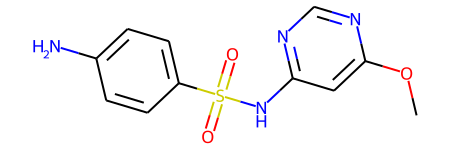

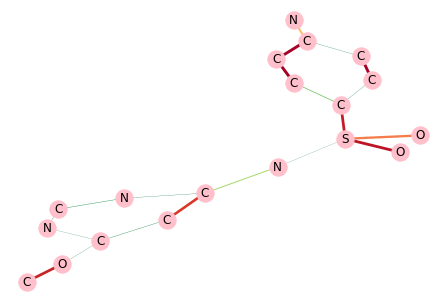

In [270]:
m = Chem.MolFromSmiles(data.smiles)
display(m)

g = to_molecule(data)
print()
draw_molecule(g, edge_index = edge_index.numpy(),
              edge_mask=edge_mask.numpy())